# Tree-based Methods
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2019
The code in this Jupyter notebook was written using Python 3.6. It uses data files `hitters.csv` and the iris dataset from scikit-learn. For the code to run properly, you will either need to have access to the internet or you should have the data file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

This notebook follows some of the material in James, et al (2013, Ch. 8). Everything in this notebook will build to the methods of Random Forests and Boosting. But it is helpful to talk about the intermediate models to build up the intuitoin for the more complex models. We will cover:

1. Basic decision trees
2. Bagging
3. Random Forests
4. Boosting

## 1. Basic decision trees
The documentation for [`scikit-learn`'s decision tree libraries](http://scikit-learn.org/stable/modules/tree.html) states, "Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features." Figures 8.1 and 8.2 from James, et al (2013) shows a basic three-region, three-leaf, three partition decision tree for the `Hitters` data from the book used to predict a professional baseball player's salary. Each partition represents a terminal node of the tree, or a leaf. The points along the ree where the predictor space is split are referred to as internal nodes. The segments that connect the nodes are called branches.

![Figure8_1.png](images/Figure8_1.png)

![Figure8_2.png](images/Figure8_2.png)

The three regions are $R_1 = \{Y_i|Years_i<4.5\}$, $R_2 = \{Y_i|Years_i\geq 4.5 \: \& \: Hits_i<117.5\}$, and $R_3 = \{Y_i|Years_i\geq 4.5 \: \& \: Hits_i\geq 117.5\}$.

More generally, to predict $Y$ using tree based methods:

1. Choose how many $P$ predictors to use in the feature space $X_1, X_2,... X_P$,
2. Divide the feature space into $J$ mutually exclusive regions $R_1, R_2,... R_J$,
3. For $Y_i\in R_j$, predict mean value $Y_i= \frac{1}{N_j}\sum_{k=1}^{N_j}Y_i$.

### 1.1. Regression trees
Regression trees are trees in which the predicted values at the leaves or terminal nodes are continuous variable values. The predicted salaries from the `Hitters` baseball wage data is the average salary in each region.

* $R_1 = \{X_i|Years_i<4.5\} = \$1,000 \times e^{5.107} \approx \$165,174 $
* $R_2 = \{X_i|Years_i\geq 4.5 \: \& \: Hits_i<117.5\} = \$1,000 \times e^{5.999} \approx \$402,834 $
* $R_3 = \{X_i|Years_i\geq 4.5 \: \& \: Hits_i\geq 117.5\} = \$1,000 \times e^{6.740} \approx \$845,346 $

**Four key questions**
1. How do we choose which feature variables to use?
2. How do we choose the cutoffs or bifurcation points for each node (e.g., $Years_i<4.5$)?
3. How do we choose which features or variables are at the base of the tree and which ones are at the ends of the branches?
4. How do we measure accuracy and fit?

Let's start with the last question (4). The structure of a decision tree--feature variables, cutoffs, and order of appearance--is chosen to minimize the residual sum of squares $RSS$ of a training data set.

$$ RSS = \sum_{j=1}^J\sum_{i\in R_j}\left(y_i - \hat{y}_i\right)^2 $$

This is equivalent to minimizing the mean squared error $MSE$ of the training set. $MSE$ only differs from the $RSS$ or $SSE$ by a scalar $1/N_j$.

$$ MSE = \frac{1}{N_j}\sum_{j=1}^J\sum_{i\in R_j}\left(y_i - \hat{y}_i\right)^2 $$

But, as with the linear regression methods and classification methods of earlier notebooks, the accuracy of the model is measured by the MSE and estimated error rate of the model on a test set. 

The answer to question (1) is up to the modeler. The cutoff/bifurcation points (2) and the order in which the variables apear in the tree from the base to the leaves (3) are chosen to minimize the RSS. We can use *recursive binary splitting* to choose the cutoff or bifurcation points of each node.

1. Solve for the predictor $X_j$ and cutoff\bifurcation $t_j$ that gives the lowest RSS in the training set. Any $X_j$ and $t_j$ divides the space into two half-planes $R_1(j,t_j)=\{X|X_j<t_j\}$ and $R_2(j,t_j)=\{X|X_j<t_j\}$. We seek the variable $X_j$ and cutoff $t_j$ that minimmize the RSS. This must be done by solving for the optimal cutoff $t_j$ for each $X_j$.

$$ (X_1, t_1) = (X_j, t_j): \quad \min_{(X_j, t_j)}\sum_{x_i\in R_1(j,t_j)}\left(y_i -\hat{y}_i\right)^2 + \sum_{x_i\in R_2(j,t_j)}\left(y_i -\hat{y}_i\right)^2 $$

2. Solve for the best predictor on each branch of the previously optimized variable by cycling through each feature $X_j$ and solving for the one in each branch with the minimum RSS.

3. Continue this process until a stopping criterion is reached (e.g., no region contains more than 5 observations.

Figure 8.3 from James, et al (2013) shows a five-region example.

![Figure8_3.png](images/Figure8_3.png)

Each possible end of a branch of the tree is called a terminal node or a leaf.

Tree is solved by recursive binary splitting.
* Which variable gives the lowest mean squared error for an optimal binary split
* On each branch of that binary split, which variable gives the lowest mean squared error for an optimal binary split
* Repeat until "some" stoppping point

You could imagine lots of possible trees based on different data. Furthermore, it is not true in general that this recursive binary splitting will give the best fit. For example, you might get the best fit by starting with a variable that does not provide the biggest reduction in MSE but does indicate other variables that provide a big reduction.

In [3]:
# Install the open source GraphViz program using
# conda install python-graphviz

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

hitters = pd.read_csv('Hitters.csv', sep=',')
# Drop observations with NaN in Salary
hitters = hitters.dropna()
print(hitters.head())
y = hitters['Salary'].values
X = hitters[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
             'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns',
             'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']].values
print(hitters.info())

   AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  CHmRun  \
1  315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   835.0    69.0   
2  479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   457.0    63.0   
3  496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0  1575.0   225.0   
4  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   101.0    12.0   
5  594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0  1133.0    19.0   

   CRuns   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
1  321.0  414.0   375.0    632.0     43.0    10.0   475.0  
2  224.0  266.0   263.0    880.0     82.0    14.0   480.0  
3  828.0  838.0   354.0    200.0     11.0     3.0   500.0  
4   48.0   46.0    33.0    805.0     40.0     4.0    91.5  
5  501.0  336.0   194.0    282.0    421.0    25.0   750.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
AtBat      263 non-null float64
Hits       263 non-null float64
HmRun      263

Lets look at the documentation for [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Key tuning parameters are:
* max_depth, min_samples_split, min_samples_leaf, max_features

In [4]:
hit_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
hit_tree.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

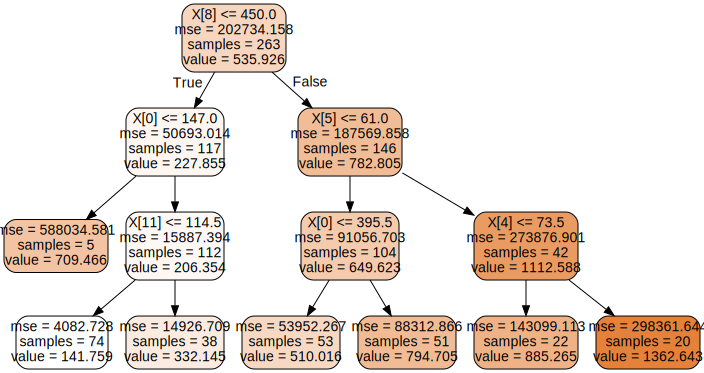

In [5]:
from sklearn.tree import export_graphviz
import graphviz

hit_tree_viz = export_graphviz(
    hit_tree,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz)
graph.render('hit_tree_viz')
graph

Now let's take the validation set approach to cross validation, break the data into training set and test set, and test the MSE of our predictor.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .4,
                                                    random_state=25)
hit_tree2 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=4)
hit_tree2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

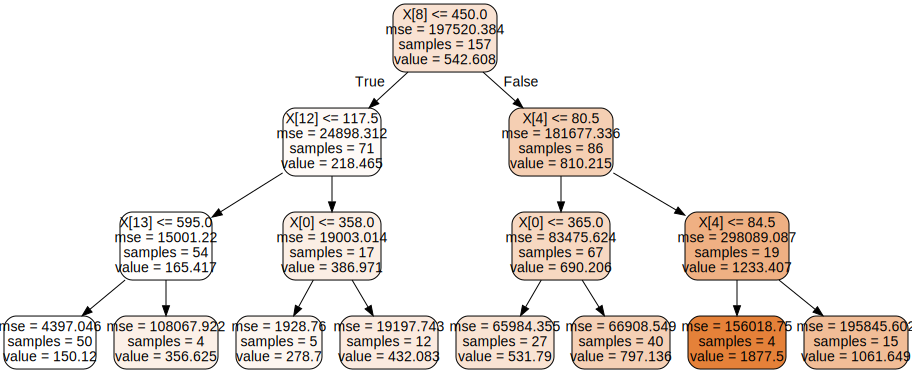

In [7]:
hit_tree_viz2 = export_graphviz(
    hit_tree2,
    out_file=None,
    # feature_names=iris.feature_names[2:],
    # class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(hit_tree_viz2)
graph.render('hit_tree_viz2')
graph

In [8]:
y_pred = hit_tree2.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE1)

MSE= 146493.11004907076


### 1.2. Tree pruning
Recursive binary splitting provides the best fit on the training set, but is likely to overfit the data and perform poorly in terms of prediction and error rate on a test set. Analogous to what we saw in the classification and regression examples, a smaller tree might predict better on a test set. Furthermore, the number of samples in a terminal node or leaf should be greater than 1.

Similar to adjusted $R$-squared and similar to lasso regression, we can use a tuning parameter $\alpha\in[0,1]$ that limits the number of branches on each tree by including a penalty to the RSS fit criterion that penalizes $|T|$ the number of terminal nodes on tree $T$. For each value of $\alpha$ there corresponds an optimal subtree $T\subset T_0$ such that:

$$ \sum_{m=1}^{|T|}\sum_{X_i\in R_m} \left(y_i - \hat{y}_i\right)^2 + \alpha|T| $$

1. Use recursive binary splitting to grow a large tree on the training data, stopping only when each terminal node has fewer than some minimum number of observations.
2. Apply cost complexity pruning to the large tree in order to obtain a sequence of best subtrees, as a function of $\alpha$.
3. Use $K$-fold cross validation ot choose $\alpha$.
4. Return the subtree from Step 2 that corresponds to the chose value of $\alpha$

This pruning currently must be coded by hand in Python. That is, `scikit-learn` does not have automatic pruning mechanisms. However, the justification is that effective pruning can be done by manipulating the parameters `max_depth`, `min_impurity_split`, `min_samples_leaf` and `min_samples_split`.

### 1.3 Classification trees
A classification tree is a decision tree that has a categorical variable as the outcome variables. For a classification tree, we predict that each observation belongs to the most commonly occurring class of training observations in the region to which it belongs. The classification error rate is simply the fraction of training observations in that region that do not belong to the most common class.

$$ ErrorRate = 1 - \max_{k}\left(\hat{p}_{m,k}\right) $$

However, classification error rate is not sensitive enough for growing trees. That is, it does not change for small changes in cutoff. For this reason, classification tree building uses either the *Gini index* or the *Entropy index* instead of the error rate.

$$ Gini = \sum_{k=1}^K \hat{p}_{m,k}\left(1 - \hat{p}_{mk}\right) $$

$$ Entropy = -\sum_{k=1}^K \hat{p}_{m,k}\ln\left(\hat{p}_{mk}\right) $$

Both the Gini index and the entropy are measures of node purity. They have values close to 0 if most of the samples in the node are in a single class (low variance) and they will both take on higher values closer to 1 if the samples in the node are in many different classes (high variance).

In [9]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

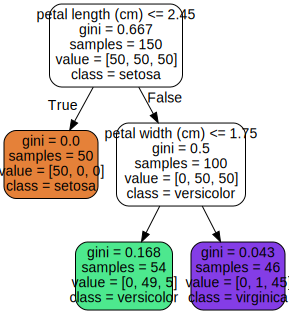

In [10]:
from sklearn.tree import export_graphviz
import graphviz

iris_tree = export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(iris_tree)
graph.render('iris')
graph

### 1.4. Tuning Hyperparameters (model selection)
In Section 1.1, we fit a number of decision tree regression models to predict $log(salary)$ using the 16 features in the data. We saw that there were some key parameters of the prediction model that influenced the model's accuracy on a test data set. In particular for the `scikit-learn.tree.DecisionTreeRegressor` model, the parameters `max_depth`, `min_samples_split`, and `min_samples_leaf` are hyperparameters that influence model prediction accuracy.

Scikit Learn has built-in methods to evaluate machine learning models and optimize them across the many different combinations of hyperparameter values. The scikit-learn documentation Section 3.2 "[Tuning the hyperparameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)" is a great reference for the different methods used for hyperparameter optimization. The particular method we will focus on in this notebook is [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This method takes random permutations of the hyperparameters and chooses the permutation that has the best fit. Another good method is [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV), which performs and exhaustive grid search of all possible permutations of specified hyperparameter values. This can be more computationally intensive than `RandomSearchCV`.

Let's optimize our hyperparameter values in the hitters problem above using `RandomSearchCV`.

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# specify parameters and distributions to sample from
param_dist1 = {'max_depth': sp_randint(2, 13),
               'min_samples_split': sp_randint(2, 15),
               'min_samples_leaf': sp_randint(1, 15)}

param_grid1 = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
               'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
               'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

hittree3 = DecisionTreeRegressor()

# Run randomized hyperparameter search
random_search1 = \
    RandomizedSearchCV(hittree3, param_distributions=param_dist1,
                       n_iter=500, n_jobs=-1, cv=5, random_state=25,
                       scoring='neg_mean_squared_error')

# Run grid search hyperparameter search
grid_search1 = \
    GridSearchCV(hittree3, param_grid=param_grid1,
                       n_jobs=-1, cv=5,
                       scoring='neg_mean_squared_error')

random_search1.fit(X, y)
print('RandBestEstimator1=', random_search1.best_estimator_)
print('RandBestParams1=', random_search1.best_params_)
print('RandBestScore1=', -random_search1.best_score_)

grid_search1.fit(X, y)
print('GridBestEstimator1=', grid_search1.best_estimator_)
print('GridBestParams1=', grid_search1.best_params_)
print('GridBestScore1=', -grid_search1.best_score_)

RandBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
RandBestParams1= {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}
RandBestScore1= 0.05055555555555556
GridBestEstimator1= DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=3, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
GridBestParams1= {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}
GridBestScore1= 0.04833333333333333


## 2. Bagging (Bootstrapping)
Decision trees constructed by recursive binary splitting are sensitive to the training set on which they are estimated. That is, if you build one tree on a random sample from a dataset, and you build another tree from a different random sample from the same dataset, both trees will likely look significantly different from each other. Bootstrapping or bagging is a general-purpose procedure for reducing the variance of any statistical learning method. It works very well with decision trees.

Bagging (or bootstrapping) is to take a large number $B$ of randomly drawn training sets from a dataset. Estimate a decision tree on each of those training sets $\hat{f}^{*b}(x)$. Then let the bagging decision tree prediction $\hat{f}_{bag}(x)$ be the average predicted value of $x$ across all the bootstrap sample trees.

$$ \hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^B \hat{f}^{*b}(x) $$

Bagging both reduces variance of the tree and increases predictive accuracy.

The bagging tree equation above must be adjusted if the dependent variable that we are trying to predict is categorical. A common way to aggregate predictions across bootstrapped training samples is to use a majority vote rule. The predicted value is the one that has the highest share of predicted values across the space.

![Figure8_8.png](images/Figure8_8.png)

Figure 8.8 from James, et al (2013) shows the results on the error rate from using a bagging approach on some `Heart` data. The number of bootstrapped samples $B$ is shown on the $x$-axis. The number of random samples need only be as big as necessary to get the error rate to settle down, which in this case is around $B=130$.

In `scikit-learn`, there is a [`BaggingRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) function for regression trees and a [`BaggingClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) function for classification trees. These methods are called "ensemble" methods because they average an "ensemble" or collection of trees. Ensemble methods are a theme in predictive models and machine learning.

Let's do a bagging version of our `max_depth=3` regression tree with the baseball salary data. Let's see if we can get the error rate down from $MSE=121264$.

In [12]:
from sklearn.ensemble import BaggingRegressor

y = hitters['Salary'].values
X = hitters[['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks',
             'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns',
             'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']].values
print(hitters.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 17 columns):
AtBat      263 non-null float64
Hits       263 non-null float64
HmRun      263 non-null float64
Runs       263 non-null float64
RBI        263 non-null float64
Walks      263 non-null float64
Years      263 non-null float64
CAtBat     263 non-null float64
CHits      263 non-null float64
CHmRun     263 non-null float64
CRuns      263 non-null float64
CRBI       263 non-null float64
CWalks     263 non-null float64
PutOuts    263 non-null float64
Assists    263 non-null float64
Errors     263 non-null float64
Salary     263 non-null float64
dtypes: float64(17)
memory usage: 37.0 KB
None


In [13]:
# n_estimators is how many samples from the data to take (the number of trees)
# max_samples is the maximum number of observations to include in each bootstrapped data sample
hit_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=53,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=25)
hit_tree3.fit(X, y)

y_pred3 = hit_tree3.oob_prediction_
MSE3 = mean_squared_error(y, y_pred3)
print('MSE=', MSE3)

MSE= 81795.88573736997


Let's plot the MSE of the bagging ensemble method as a function of the number of trees in order to estimate the optimal number of samples that gives the highest predictive accuracy.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:1011: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:1011: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:1011: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/bagging.py:1011: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do

Min. MSE= 78683.17842347568 , Min. B= 53


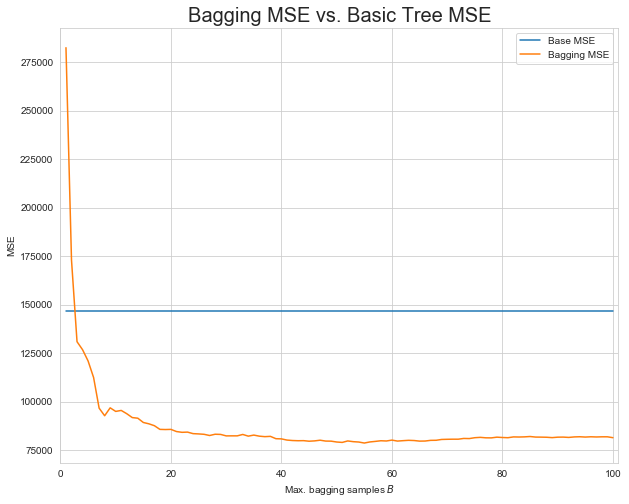

In [14]:
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

MSE_base = MSE1
max_samples = 100
MSE_vec = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    hit_tree_loop = BaggingRegressor(DecisionTreeRegressor(), n_estimators=ind,
                                 max_samples=100, bootstrap=True, oob_score=True,
                                 random_state=15)
    hit_tree_loop.fit(X, y)
    y_pred_loop = hit_tree_loop.oob_prediction_
    MSE_vec[ind - 1] = mean_squared_error(y, y_pred_loop)
    # print('MSE=', MSE_vec[ind - 1])

fig, ax = plt.subplots()
plt.plot(np.arange(1, max_samples + 1), MSE_base * np.ones(max_samples),
         label='Base MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec, label='Bagging MSE')
# for the minor ticks, use no labels; default NullFormatter
plt.title('Bagging MSE vs. Basic Tree MSE', fontsize=20)
plt.xlabel(r'Max. bagging samples $B$')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.legend(loc='best')

print('Min. MSE=', MSE_vec.min(), ', Min. B=', np.argwhere(MSE_vec == MSE_vec.min())[0, 0] - 1)

In [15]:
MSE_hat = MSE_vec[52:].mean()
MSE_std = MSE_vec[52:].std()
print('mean MSE=', MSE_hat, ', standard error=', MSE_std)

mean MSE= 80906.98626992443 , standard error= 952.790216699083


You probably noticed that we used some options that included the acronym OOB. With bagging (bootstrapped training samples), "one can show that, on average, each bagged tree makes use of around two-thirds of the observations. The remaining one-third are referred to as *out of bag* (OOB) observations." OOB error rate estimation is to use all the trees in the ensemble to predict the out of bag observations. This results in approximately $B/3$ predictions for each observation. The predicted value is then the average of all the predictions.

It can be shown that with $B$ sufficiently large, OOB error rate approaches the leave-one-out cross-validation (LOOCV) error rate. OOB is faster and more efficient than the method of averaging error rates for each random sample.

## 3. Random Forests
Bagging solves the problem of sensitivity of the estimated trees to the sample drawn for the training set by taking many samples and averaging the predictions. However, bagging does not solve the issue that the trees' structure in each sample will be correlated due to the trees using the same group of features in each sample. Random forest decision trees add one more layer of randomization that reduces the correlation in the trees that comes from a constant feature set.

A random forest continues the bagging (bootstrapping) approach, but causes each tree from a sample of observations to have a randomly determined subset of features. In other words, each tree can only use a small subset of features. The intuition is the following. Randomizing the features allows us to better explore the full set of possible predictors. A typical number of features $m$ to limit each tree to use is $m=\sqrt{P}$. This may require more bootstrapped (bagging) draws, but random forests have been shown to have better predictive accuracy than bagging alone.

`Scikit-learn` also has functions to execute random forests. [`RandomForestRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) estimates a random forest decision tree regression model, and [`RandomForestClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) estimates a random forest decision tree classifier model.

In [16]:
from sklearn.ensemble import RandomForestRegressor

B4 =100
m4 = 4
hit_tree4 = RandomForestRegressor(n_estimators=B4, max_features=m4, bootstrap=True,
                                  n_jobs=-1, oob_score=True, random_state=25)
hit_tree4.fit(X, y)

print('OOB score=', hit_tree4.score(X, y))
y_pred4 = hit_tree4.oob_prediction_
MSE4 = mean_squared_error(y, y_pred4)
print('MSE=', MSE4)

OOB score= 0.9478338447824203
MSE= 80046.73280409168


Let's compare the baseline MSE, versus the bagging MSE, versus the random forest MSE as a function of the number of random draw training sets.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

Min. bag MSE= 78683.17842347568 , Min. bag B= 53
Min. rnd MSE= 75037.00760916114 , Min. rnd B= 48


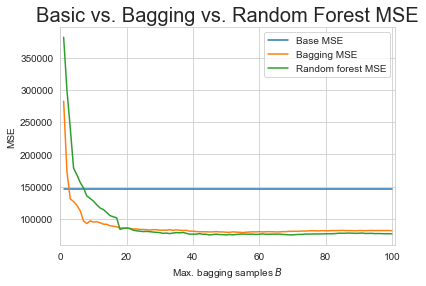

In [17]:
max_samples = 100
MSE_vec4 = np.zeros(max_samples)
for ind in range(1, max_samples + 1):
    hit_tree4_loop = RandomForestRegressor(n_estimators=ind, max_features='sqrt',
                                           bootstrap=True, oob_score=True,
                                           random_state=15)
    hit_tree4_loop.fit(X, y)
    y_pred4_loop = hit_tree4_loop.oob_prediction_
    MSE_vec4[ind - 1] = mean_squared_error(y, y_pred4_loop)
    # print('MSE=', MSE_vec[ind - 1])

fig, ax = plt.subplots()
plt.plot(np.arange(1, max_samples + 1), MSE_base * np.ones(max_samples),
         label='Base MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec, label='Bagging MSE')
plt.plot(np.arange(1, max_samples + 1), MSE_vec4, label='Random forest MSE')
# for the minor ticks, use no labels; default NullFormatter
plt.title('Basic vs. Bagging vs. Random Forest MSE', fontsize=20)
plt.xlabel(r'Max. bagging samples $B$')
plt.ylabel(r'MSE')
plt.xlim((0, max_samples + 1))
plt.legend(loc='best')

print('Min. bag MSE=', MSE_vec.min(), ', Min. bag B=', np.argwhere(MSE_vec == MSE_vec.min())[0, 0] - 1)
print('Min. rnd MSE=', MSE_vec4.min(), ', Min. rnd B=', np.argwhere(MSE_vec4 == MSE_vec4.min())[0, 0] - 1)

## 4. Boosting
"Unlike fitting a single large decision tree to the data, which amounts to fitting the data hard and potentially overfitting, the boosting approach instead learns slowly. Given the current model, we fit a decision tree to the residuals from the model. That is, we fit a tree using the current residuals, rather than the outcome $Y$, as the response."

"By fitting small trees to the residuals, we slowly improve $\hat{f}$ in areas where it does not perform well."

The figure below is Figure 8.11 from James, et al (2013). This shows MSE performance of two boosting models versus a random forest on predicting cancer cells versus normal cells.

![Figure8_11.png](images/Figure8_11.png)

## References
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, [*An Introduction to Statistical Learning with Applications in R*](http://link.springer.com.proxy.uchicago.edu/book/10.1007%2F978-1-4614-7138-7), New York, Springer (2013).